In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

## Задание 1.
Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
mse = lambda y, z: np.mean((y - z)**2)
bias = lambda y, z: y - z #функция потерь L2 loss

In [3]:
def gb_predict(X, trees, coefs, eta):#предсказание по обученным деревьям
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees, coefs)]) for x in X])

In [4]:
def gb_fit(n_trees, max_depth, X, y, coefs, eta):#обучение модели
    trees = []  
    
    for i in range(n_trees):
        target = np.zeros(shape=y.shape) if len(trees) == 0 else gb_predict(X, trees, coefs, eta)
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X, bias(y, target))
        trees.append(tree)        
    return trees
    trees = []
    
    for i in range(n_trees):
        target = np.zeros(shape=y.shape) if len(trees) == 0 else gb_predict(X, trees, coefs, eta)
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X, bias(y, target))
        trees.append(tree)        
    return trees

In [5]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=10)

Начальные коэффициенты $\gamma = 1$, максимальная глубина деревьев 3, шаг градиентного бустинга $\eta = 0.1$. Меняем число деревьев от 1 до 30.

In [6]:
max_depth = 3
eta = 0.1
n_trees_max = 30
n_trees_arr = [i+1 for i in range(n_trees_max)]

coefs = np.ones(n_trees_max)
trees = gb_fit(n_trees_max, max_depth, X_train, y_train, coefs, eta)

In [7]:
train_errors = []
test_errors = []

for n_trees in n_trees_arr:
    y_train_pred = gb_predict(X_train, trees[0:n_trees], coefs[0:n_trees], eta)
    y_test_pred = gb_predict(X_test, trees[0:n_trees], coefs[0:n_trees], eta)

    train_errors.append(mse(y_train, y_train_pred))
    test_errors.append(mse(y_test, y_test_pred))

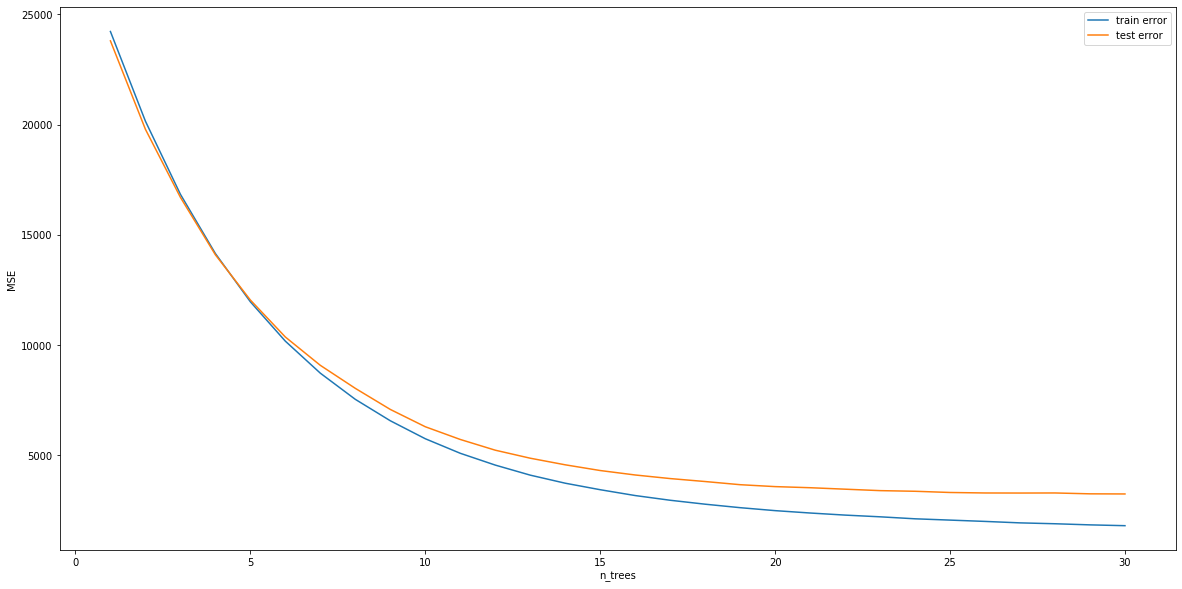

In [8]:
plt.figure(figsize=(20,10))
plt.plot(n_trees_arr, train_errors, label='train error')
plt.plot(n_trees_arr, test_errors, label='test error')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

При увеличении числа деревьев точность модели увеличивается. Переобучение не наступает из-за маленького шага градиентного бустинга. Теперь зададим число деревьев равное 10. Будем менять глубину деревьев от 1 до 30.

In [9]:
n_trees = 10
eta = 0.1
coefs = np.ones(n_trees)

train_errors = []
test_errors = []

max_depth_arr = np.arange(1, 31, 1)

for max_depth in max_depth_arr:
    trees = gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta)

    y_train_pred = gb_predict(X_train, trees, coefs, eta)
    y_test_pred = gb_predict(X_test, trees, coefs, eta)

    train_errors.append(mse(y_train, y_train_pred))
    test_errors.append(mse(y_test, y_test_pred))

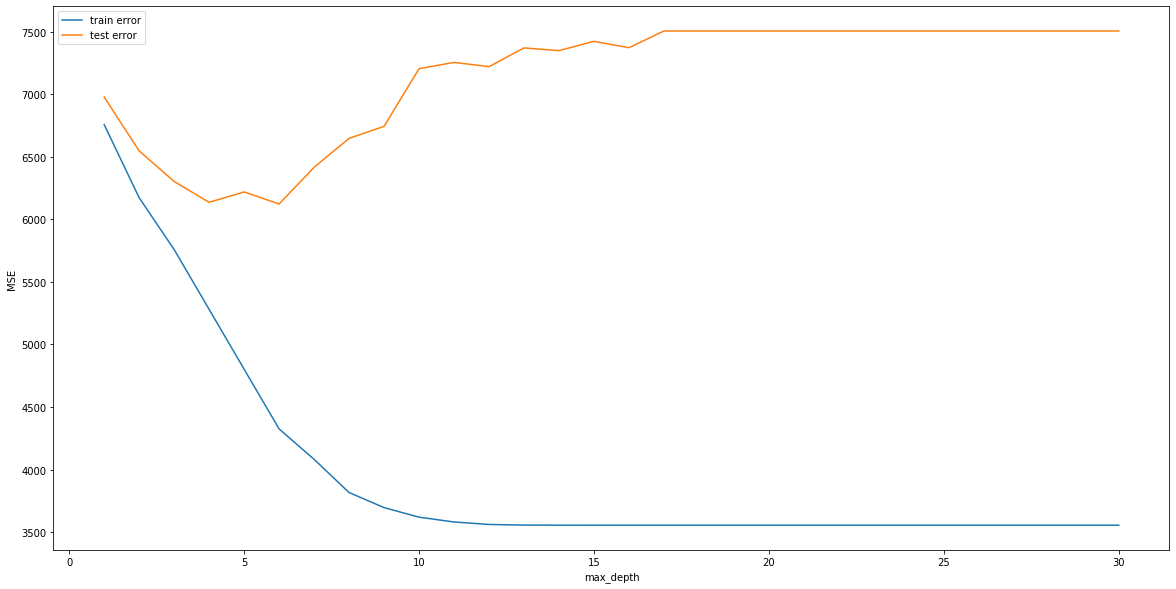

In [10]:
plt.figure(figsize=(20,10))
plt.plot(max_depth_arr, train_errors, label='train error')
plt.plot(max_depth_arr, test_errors, label='test error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

С увеличением глубины деревьев, точность на тиренировочной выборке растёт, а на тестовой в какой-то момент начинает уменьшаться. Модель переобучается.
Для оценки метода градиентного бустинга, найдём mse для идеальной модели линейной регрессии, построенной аналитически.

In [11]:
w = np.linalg.inv((X.T @ X)) @ X.T @ y
w # вектор весов идеальной линейной модели

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

In [12]:
round(mse(X @ w, y),2)

26004.29

Получили ошибку mse = 26004,29. Линейные модели не позволяют получить большей точности, эта ошибка обусловлена шумом в исходных данных. При правильном подборе параметров модели градиентного бустинга можно получить гораздо более точный результат, чем при построении модели линейной регрессии.

## Задание 2*. 
Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [13]:
def get_bootstrap(data, labels, alpha):#Получение бутстрап-выбороки
    n_samples = int(alpha * X.shape[0])
    sample_indexes = [random.randint(0, n_samples-1) for _ in range(n_samples)]
    
    return data[sample_indexes], labels[sample_indexes]

In [14]:
def gb_fit_bootstarap(n_trees, max_depth, X, y, coefs, eta):#обучение модели со стохастическим градиентным бустингом
    trees = []    

    for i in range(n_trees):
        X_bootstrap, y_bootstrap = get_bootstrap(X, y, 0.5)
        target = np.zeros(shape=y_bootstrap.shape) if len(trees) == 0 else gb_predict(X_bootstrap, trees, coefs, eta)
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X_bootstrap, bias(y_bootstrap, target))
        trees.append(tree)
        
    return trees

In [15]:
max_depth = 5
eta = 0.1
n_trees_max = 50
n_trees_arr = [i+1 for i in range(n_trees_max)]
coefs = np.ones(n_trees_max)
# деревья, построенные на тренировочной выборке без бутстрапирования выборки
trees = gb_fit(n_trees_max, max_depth, X_train, y_train, coefs, eta)
# деревья, построенные с применением бутстрапирования на тренировочной выборке
trees_b = gb_fit_bootstarap(n_trees_max, max_depth, X_train, y_train, coefs, eta)

In [16]:
test_errors = []
train_errors = []
test_errors_b = []
train_errors_b = []

for n_trees in n_trees_arr:
    # градиентный бустинг
    y_test_pred = gb_predict(X_test, trees[0:n_trees], coefs[0:n_trees], eta)
    y_train_pred = gb_predict(X_train, trees[0:n_trees], coefs[0:n_trees], eta)

    test_errors.append(mse(y_test, y_test_pred))
    train_errors.append(mse(y_train, y_train_pred))

    # стохастический градиентный бустинг
    y_test_pred_b = gb_predict(X_test, trees_b[0:n_trees], coefs[0:n_trees], eta)
    y_train_pred_b = gb_predict(X_train, trees_b[0:n_trees], coefs[0:n_trees], eta)

    test_errors_b.append(mse(y_test, y_test_pred_b))
    train_errors_b.append(mse(y_train, y_train_pred_b))

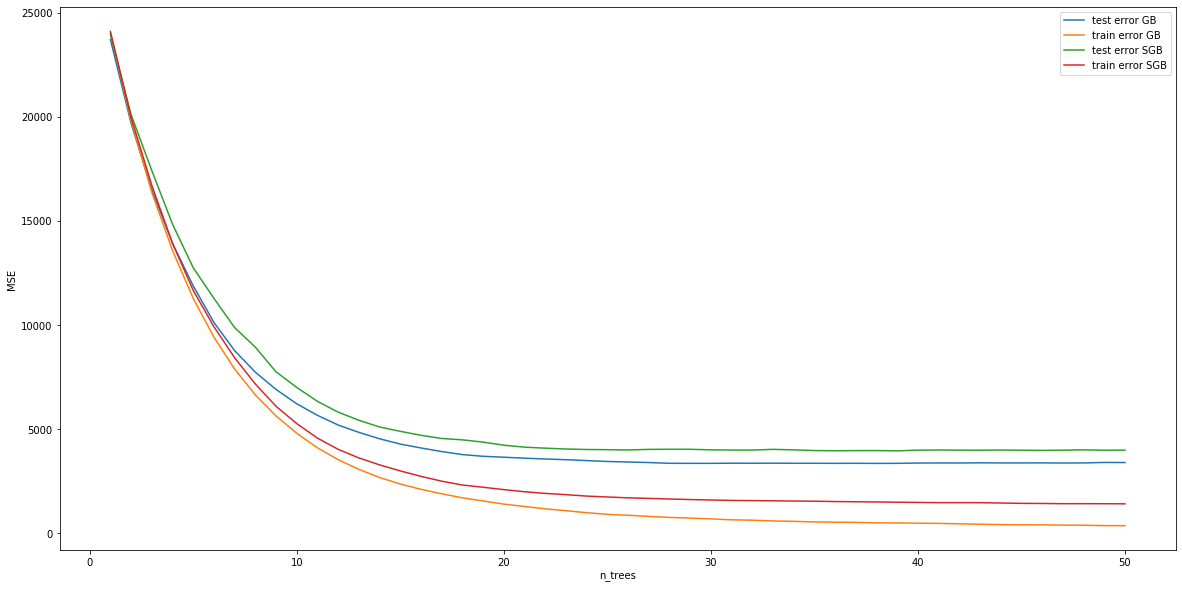

In [17]:
plt.figure(figsize=(20,10))
plt.plot(n_trees_arr, test_errors, label='test error GB')
plt.plot(n_trees_arr, train_errors, label='train error GB')
plt.plot(n_trees_arr, test_errors_b, label='test error SGB')
plt.plot(n_trees_arr, train_errors_b, label='train error SGB')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

Результат примерно одинаковый. При большом количестве шагов результат у модели стохастического градиентного бустинга чуть лучше.